# Battle of the Neighborhoods
## Model_cluster

__Table of Contents__

* [Feature-selection](#Feature-selection)
* [K-Means](#K-Means)
* [Summary](#Summary)

![](https://vignette.wikia.nocookie.net/phineasandferb/images/9/9b/Treehouse_Fight.jpg/revision/latest?cb=20090320212850)

__The story so far...__

In the notebook 'intro_data.ipynb', the [motivation](intro_data.ipynb#Introduction) for building a sports facility was outlined. [Data](intro_data.ipynb#Data) was also collected using Google Place API, and stored in JSON files. This data was collected for ten venue categories:
[Sports facilities, cinemas, pubs, gyms, banks, hospitals, supermarkets, schools, colleges, and restaurants](intro_data.ipynb#Points-of-interest-in-Hyderabad).

In 'preprocessing.ipynb', a large dataset of locations was built. The locations of existing sports facilities was supplemented with locations chosen randomly (uniformly) from the city. For all of these locations, the distances to ten nearest venues for each of the ten venue categories was calculated. This distance data was cast to a pandas DataFrame and subsequently stored to disk to the file 'fullDataset.json'.

In 'model_binary.ipynb', the dataset was used to train simple logistic regression models. Proximity to the closest sports venue was used as the suitability score, and then thresholded to obtain class labels - either suitable or unsuitable. The class imbalance in the data turned out to be a problem with binary classifiers. Trying to balance the data made things a bit too messy.

$~$

In 'model_continuous.ipynb', the suitability score (proximity to nearest sports venue) was used as the continuous target value. A simple linear regressions model was built, producing an $R^2$ of 0.5. A single layer perceptron pushed $R^2$ to 0.68 with 125 hidden units, and a multi layer perceptron with 3 hidden layers and (125,25,5) hidden units pushed $R^2$ further to 0.72. The errors were evenly distributed about zero, if not normally distributed. There was some bias at the low and high ends of target values.  

$~$

__In this notebook...__

We do away with suitability scores and do clustering instead. The aim is to see if the locations for all of the existing sports facilities fall nicely into one or a few clusters, separated from most of the other locations. We will not do any fancy clustering - just simple K-means with a few random initial seed. Because this project has already taken me much longer than I hoped it would. 


In [5]:
import json
import numpy as np
import pandas as pd
import time # Will use sleep from time to pause 
import matplotlib.pyplot as plt
import folium
import numpy.ma as ma

from warnings import warn
%matplotlib inline

In [6]:
df_full = pd.read_json('fullDataset.json')
venueCats = ["sports", "cinemas", "pubs", "gyms", "banks", 
             "hospitals", "supermarkets", "schools", "colleges", "restaurants"]
venueCats = sorted(venueCats, key=str.lower)

# Because we consider distances to other venues when defining features
# and distance to sports facilities when defining output labels and scores
venueCats_sans_sports = venueCats.copy()
venueCats_sans_sports.remove('sports')

# Location of the center of the city: 
# The location of the "Buddha Statue" in a lake called "Hussain Sagar" at the center of the city is used
latCC = lat_CC = 17.415435
lngCC = lng_CC = 78.474296

df_full.reset_index(drop=True, inplace=True)

print(venueCats)
print(df_full.columns[3:].values)

n_nbrs = len(df_full.iloc[0,5])  
print("Using n_nbrs:",n_nbrs)
df_full.head()

['banks', 'cinemas', 'colleges', 'gyms', 'hospitals', 'pubs', 'restaurants', 'schools', 'sports', 'supermarkets']
['banks' 'cinemas' 'colleges' 'gyms' 'hospitals' 'pubs' 'restaurants'
 'schools' 'sports' 'supermarkets']
Using n_nbrs: 10


,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5333915503, 78.3019480094]",17.533392,78.301948,"[0.5944527837, 0.9123336302, 1.1945137594, 1.2...","[2.5226926821999998, 2.7441248317999998, 3.292...","[2.2231445958, 2.4326837456, 2.5586923999, 2.6...","[0.4141267293, 0.6469971331000001, 1.470688927...","[2.4209027735, 2.6356289195000002, 2.651096537...","[0.4326443585, 2.0161228142, 2.0193793055, 2.0...","[2.8365380395, 2.8365380395, 3.6162430067, 4.7...","[0.3709854836, 0.5719475071, 0.5819651468, 0.6...","[0.9887859477000001, 1.5864883539, 1.615919187...","[1.5239640962, 2.0930682862, 2.4115800549, 2.6..."
1,"[17.4942544, 78.1426446]",17.494254,78.142645,"[0.6754174845, 0.6909662965000001, 0.746231804...","[4.2429786787, 4.5061204992, 7.7483776384, 8.4...","[0.1316769686, 1.8442535139, 3.9067855433, 3.9...","[0.14670746310000002, 1.0841352373, 1.67283942...","[3.8287129508, 4.5275674007, 4.5310875347, 4.5...","[4.5335069359, 4.7413597513, 8.7463913996, 8.9...","[10.3520028636, 16.9519428463, 16.9519428463, ...","[0.5237399309, 0.5316808758, 0.924419337700000...","[0.0, 0.018022444000000002, 0.0319378584, 0.96...","[13.9095550906, 13.9142012707, 14.3331331326, ..."
2,"[17.2736776385, 78.5670567671]",17.273678,78.567057,"[2.2614932277, 2.2624956284, 2.2690632559, 2.2...","[6.4672878001, 6.9237351057000005, 6.956319766...","[1.2465647364, 1.7114100722, 1.9511505964, 2.0...","[1.9511606865000002, 2.1844757094, 2.228745610...","[5.5789316488, 6.0012584187, 6.064016701, 6.44...","[1.2535245812, 3.3873357157, 3.7890114492, 5.2...","[6.7748896167, 7.4194043843, 7.4250739684, 7.4...","[0.9387879407, 1.1159395825, 1.1597221395, 1.2...","[1.6722465827000002, 2.8126944449, 2.976785561...","[2.2234366467, 5.2608094770000005, 5.279426647..."
3,"[17.2159971208, 78.5018378083]",17.215997,78.501838,"[1.0231317789, 1.0290610733, 1.552344901600000...","[2.8466319478, 7.118468551, 11.137838919, 11.4...","[2.667688001, 2.7771837433, 2.8335145658, 2.84...","[0.8044426591, 0.9004906079, 2.6654642685, 2.7...","[11.6441161148, 11.821180716, 12.5591125675, 1...","[5.8143442376, 7.8437278947, 7.905480393599999...","[3.6821682024999998, 7.8654203973, 7.942906800...","[0.9962343093, 1.0744389745, 1.902801744, 2.60...","[0.6524729677000001, 2.9911387450999998, 4.248...","[4.7284731381, 10.1528607584, 11.1395369905, 1..."
4,"[17.5405338, 78.3857611]",17.540534,78.385761,"[0.17909229840000002, 0.773952089, 1.214674442...","[4.1980559378, 4.278676515, 4.278676515, 4.480...","[0.17714835180000002, 0.2923846075, 0.76939061...","[0.9023824009, 1.5523972775, 1.5571471251, 2.0...","[2.720175495, 4.302153125, 4.3027458242, 4.588...","[2.2791124241, 3.0928239586, 3.8176102177, 3.8...","[2.2898091591, 3.0622868938, 3.2388035882, 4.5...","[0.0762680701, 0.28190401390000003, 0.36464936...","[0.0, 0.0231518678, 0.0493814418, 0.0514730139...","[2.2811736948, 2.2908107154, 2.2976849177, 2.3..."


In [7]:
# Convert all distance lists in df_full to numpy arrays
df_full.loc[:,venueCats] = df_full.loc[:,venueCats].applymap(lambda x: np.array(x))
type(df_full.iloc[0,4])

numpy.ndarray

### Train - test split

I will not do any train-test splits. In fact, I will not do any testing at all. Because I can't quite figure out what to test on. 

### Loss function

There is none. At least none that I can think of. 

### Methodology

I will take all of the data I have to do clustering. Once I have cluster centers and cluster labels for each datapoint, I will see if the existing facilities fall predominantly into any of the clusters. Supposing they do, if they make up a majority of points in the cluster. The features I will use are from the prox_n and prox_0_n methods. Because they have a nice scaling, unlike distances, which can get quite large. 

I will do the clustering using two metric - Euclidean distance, and cosine distance. Hopefully, one of them will give me a reasonable clustering. 

# Feature selection

In [8]:
proximityFun = lambda dist : (1.)/(1.+(dist/0.5))

# First, define a function that takes venue category and location as input,
#    and returns an associated feature (scalar or vector)
# Then, we build a class of such functions

def dist_n(dfTmp, venueCat, n=2):
    """ Returns distance to (n+1)^th closest venue of category venueCat for all locations in dfTmp. n Defaults to 2.
    n can take values 0 to n_nbrs-1 (inclusive). """
    return dfTmp[venueCat].apply(lambda x: x[n]).to_numpy().reshape((-1,1))

def prox_n(dfTmp, venueCat, n=2):
    """ Returns proximity to (n+1)^th closest venue of category venueCat for all locations in dfTmp. 
    n defaults to 2. 
    n can take values 0 to n_nbrs-1 (inclusive) """
    return dfTmp[venueCat].apply(lambda x: proximityFun(x[n]) ).to_numpy().reshape((-1,1))

def dist_0_n(dfTmp, venueCat, n=2):
    """ Returns distance to 1st to (n+1)^th closest venue of category venueCat for all locations in dfTmp. n Defaults to 2.
    n can take values 0 to n_nbrs-1 (inclusive). """
    n = min(n,n_nbrs-1)
    return np.array(dfTmp[venueCat].apply(lambda x: x[:n+1] ).to_list()).reshape((-1,n+1))
    

def prox_0_n(dfTmp, venueCat, n=2):
    """ Returns proximity to 1st to (n+1)^th closest venue of category venueCat for all locations in dfTmp. 
    n defaults to 2. 
    n can take values 0 to n_nbrs-1 (inclusive) """
    n = min(n,n_nbrs-1)
    return np.array(dfTmp[venueCat].apply(lambda x: proximityFun(np.array(x[:n+1]) ) ).to_list()).reshape((-1,n+1))


def featureVector(dfTmp,featureFun=prox_n, **kwargs):
    """ Returns vector containing features associated to a location 
    Positional arguments:
        lat : Latitude
        lng : Longitude
    Keyword arguments:
        featureFun : Callable that takes arguments (venueCat, **kwargs) to define features
                        Defaults to feature_prox_n                    
        **kwargs : Passed directly to featureFun
    
    Returns:
        featureVec : pd.Series of shape (m*N,), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert venueCats_sans_sports == sorted(venueCats_sans_sports, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
       
    featureArr0 = featureFun(dfTmp,venueCats_sans_sports[0], **kwargs) # Features for category 0
    assert isinstance(featureArr0, np.ndarray) and featureArr0.ndim == 2
    m = featureArr0.shape[1]
    featureArr = np.zeros( (len(dfTmp), m * (len(venueCats_sans_sports)) ) )  # Initialize array for all cats,except sports
    featureArr[:,:m] = featureArr0 # Assign features for cat 0
    
    # Assign features for other categories
    for index in range(1, len(venueCats_sans_sports)):
        featureArr[:,index * m : (index+1) * m ] = featureFun(dfTmp,
                                venueCats_sans_sports[index], **kwargs)
    
    return featureArr

def featureVector_small(dfTmp,vCats_small, featureFun=prox_n, **kwargs):
    """ Returns vector containing features associated with locations in dfTmp
    Positional arguments:
        dfTmp: DataFrame containing distances to n_nbrs nearest neighbors
        vCats_small: A subset of venueCats to use a limited set of features
    Keyword arguments:
        featureFun : Callable that takes arguments (venueCat, **kwargs) to define features
                        Defaults to feature_prox_n                    
        **kwargs : Passed directly to featureFun
    
    Returns:
        featureVec : np.ndarray of shape ( len(dfTmp), m*N ), where m is number of floats returned by featureFun,
                        N is len(venueCats)-1
    """
    assert vCats_small == sorted(vCats_small, key=str.lower)  
    # Ensure venueCats_sans_sports properly ordered
    
       
    featureArr0 = featureFun(dfTmp,vCats_small[0], **kwargs) # Features for category 0
    assert isinstance(featureArr0, np.ndarray) and featureArr0.ndim == 2
    m = featureArr0.shape[1]
    featureArr = np.zeros( (len(dfTmp), m * (len(vCats_small)) ) )  # Initialize array for all cats,except sports
    featureArr[:,:m] = featureArr0 # Assign features for cat 0
    
    # Assign features for other categories
    for index in range(1, len(vCats_small)):
        featureArr[:,index * m : (index+1) * m ] = featureFun(dfTmp,
                                vCats_small[index], **kwargs)
    
    return featureArr


def labelArr(dfTmp):
    return prox_n(dfTmp, 'sports',n=0).flatten()


In [9]:
df = df_full
df.head()

,Location,Latitude,Longitude,banks,cinemas,colleges,gyms,hospitals,pubs,restaurants,schools,sports,supermarkets
0,"[17.5333915503, 78.3019480094]",17.533392,78.301948,"[0.5944527837, 0.9123336302, 1.1945137594, 1.2...","[2.5226926821999998, 2.7441248317999998, 3.292...","[2.2231445958, 2.4326837456, 2.5586923999, 2.6...","[0.4141267293, 0.6469971331000001, 1.470688927...","[2.4209027735, 2.6356289195000002, 2.651096537...","[0.4326443585, 2.0161228142, 2.0193793055, 2.0...","[2.8365380395, 2.8365380395, 3.6162430067, 4.7...","[0.3709854836, 0.5719475071, 0.5819651468, 0.6...","[0.9887859477000001, 1.5864883539, 1.615919187...","[1.5239640962, 2.0930682862, 2.4115800549, 2.6..."
1,"[17.4942544, 78.1426446]",17.494254,78.142645,"[0.6754174845, 0.6909662965000001, 0.746231804...","[4.2429786787, 4.5061204992, 7.7483776384, 8.4...","[0.1316769686, 1.8442535139, 3.9067855433, 3.9...","[0.14670746310000002, 1.0841352373, 1.67283942...","[3.8287129508, 4.5275674007, 4.5310875347, 4.5...","[4.5335069359, 4.7413597513, 8.7463913996, 8.9...","[10.3520028636, 16.9519428463, 16.9519428463, ...","[0.5237399309, 0.5316808758, 0.924419337700000...","[0.0, 0.018022444000000002, 0.0319378584, 0.96...","[13.9095550906, 13.9142012707, 14.3331331326, ..."
2,"[17.2736776385, 78.5670567671]",17.273678,78.567057,"[2.2614932277, 2.2624956284, 2.2690632559, 2.2...","[6.4672878001, 6.9237351057000005, 6.956319766...","[1.2465647364, 1.7114100722, 1.9511505964, 2.0...","[1.9511606865000002, 2.1844757094, 2.228745610...","[5.5789316488, 6.0012584187, 6.064016701, 6.44...","[1.2535245812, 3.3873357157, 3.7890114492, 5.2...","[6.7748896167, 7.4194043843, 7.4250739684, 7.4...","[0.9387879407, 1.1159395825, 1.1597221395, 1.2...","[1.6722465827000002, 2.8126944449, 2.976785561...","[2.2234366467, 5.2608094770000005, 5.279426647..."
3,"[17.2159971208, 78.5018378083]",17.215997,78.501838,"[1.0231317789, 1.0290610733, 1.552344901600000...","[2.8466319478, 7.118468551, 11.137838919, 11.4...","[2.667688001, 2.7771837433, 2.8335145658, 2.84...","[0.8044426591, 0.9004906079, 2.6654642685, 2.7...","[11.6441161148, 11.821180716, 12.5591125675, 1...","[5.8143442376, 7.8437278947, 7.905480393599999...","[3.6821682024999998, 7.8654203973, 7.942906800...","[0.9962343093, 1.0744389745, 1.902801744, 2.60...","[0.6524729677000001, 2.9911387450999998, 4.248...","[4.7284731381, 10.1528607584, 11.1395369905, 1..."
4,"[17.5405338, 78.3857611]",17.540534,78.385761,"[0.17909229840000002, 0.773952089, 1.214674442...","[4.1980559378, 4.278676515, 4.278676515, 4.480...","[0.17714835180000002, 0.2923846075, 0.76939061...","[0.9023824009, 1.5523972775, 1.5571471251, 2.0...","[2.720175495, 4.302153125, 4.3027458242, 4.588...","[2.2791124241, 3.0928239586, 3.8176102177, 3.8...","[2.2898091591, 3.0622868938, 3.2388035882, 4.5...","[0.0762680701, 0.28190401390000003, 0.36464936...","[0.0, 0.0231518678, 0.0493814418, 0.0514730139...","[2.2811736948, 2.2908107154, 2.2976849177, 2.3..."


# K-Means

## Using proximity to closest venue

That is, we use features from prox_n(n=0). 

In [10]:
from sklearn.cluster import KMeans

y = labelArr(df) # Use this later for plotting

In [69]:
import random
r = lambda: random.randint(0,255)
bins = [0., 0.2, 1./3., 0.5, 1.] # Split data into 3 bins
# The bins are for proximity to nearest sports facility. 
# A proximity of 0.5 represents a 0.5 km radius, and a proximity of 1/3 represents a 1 km radius
#   and a proximity of 0.2 represents a 2km radius.
    
def plot_clusters(y, pred_clusters, title,plot_vars=False, featFun=None,n=None):
    n_clusters = np.amax(pred_clusters) + 1
    
    
    counts = np.zeros((n_clusters, 3)) 
    clrList = []
    
    print()
    print("=======================")
    print("             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]")
    for ind in range(n_clusters):
        clrList.append('#%02X%02X%02X' % (r(),r(),r()))   # Generate random color for each cluster
        
        # Suitability scores belonging to the cluster:
        y_cls = y[pred_clusters == ind]
        counts = np.histogram(y_cls, bins=bins, density=False)[0]
        print("cluster{} : {:11d}  | {:11d} | {:11d} | {:11d}".format(ind, *list(counts)))

    binArr = np.copy(y)
    binArr[binArr<bins[1]] = 0
    binArr[np.logical_and(bins[1] <= binArr, binArr<bins[2]) ] = 1
    binArr[np.logical_and(bins[2] <= binArr, binArr<bins[3]) ] = 2
    binArr[bins[3] <= binArr] = 3
    binArr = binArr.astype(int)
    
    binMarkers = ['P', 'X', 'v', 's']
        
    clrArr = [clrList[k] for k in pred_clusters]    
    
    if not plot_vars:
        plt.figure()
        for ind in range(n_clusters):
            plt.scatter(y, pred_clusters, c=clrArr,marker='x', s=6)

        plt.title(title)
        plt.xlabel("True suitability score")
        plt.ylabel("Cluster number")
        plt.show()
    else :
        fig = plt.figure(figsize=(12,5))
        fig.suptitle(title)

        # First subplot
        ax = fig.add_subplot(1,2,1)
        for ind in range(n_clusters):
            ax.scatter(y, pred_clusters, c=clrArr, marker='x', s=6)

        ax.set_xlabel("True suitability score")
        ax.set_ylabel("Cluster number")
        
        # Second subplot
        ax = fig.add_subplot(1,2,2)
        # Plot distance/proximity to colleges on x-axis
        feat_colleges = featFun(df, 'colleges',n=n)
        # Plot distance/proximity to restaurants on y-axis
        feat_restaurants = featFun(df, 'restaurants', n=n)
        ax.set_xlabel("feat_colleges")
        ax.set_ylabel("feat_restaurants")
        clrArr = np.array(clrArr)
        for ind in range(n_clusters):
            for binInd in range(4):
                ax.scatter(feat_colleges[binArr==binInd], feat_restaurants[binArr==binInd], 
                           c=clrArr[binArr==binInd], marker=binMarkers[binInd], s=6,facecolors='none')
        
        plt.show()


### Features from dist_n : distance to $n^{th}$ nearest venue of each category


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1123  |        1132 |         962 |        1369
cluster1 :        2611  |         532 |         168 |         133


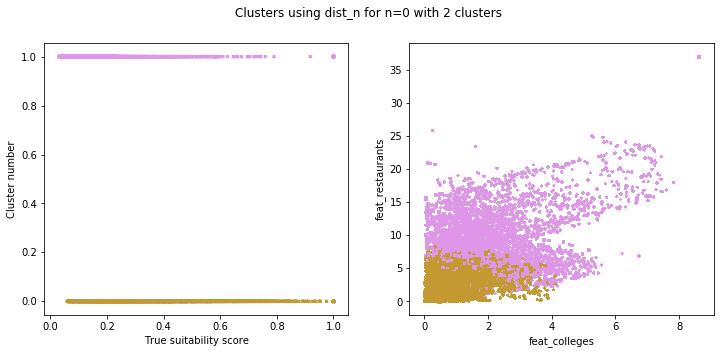


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2224  |         589 |         213 |         140
cluster1 :         702  |         990 |         894 |        1320
cluster2 :         808  |          85 |          23 |          42


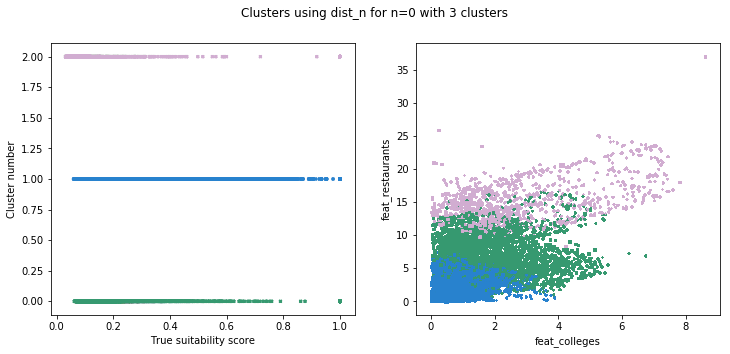


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         459  |         886 |         854 |        1275
cluster1 :        1249  |         258 |          80 |          78
cluster2 :        1678  |         520 |         196 |         144
cluster3 :         348  |           0 |           0 |           5


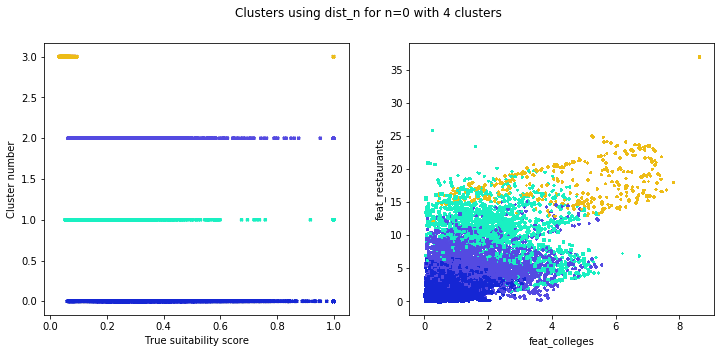


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         403  |          91 |          30 |          27
cluster1 :        1028  |         235 |          69 |          64
cluster2 :         362  |           0 |           0 |           5
cluster3 :        1533  |         480 |         185 |         136
cluster4 :         408  |         858 |         846 |        1270


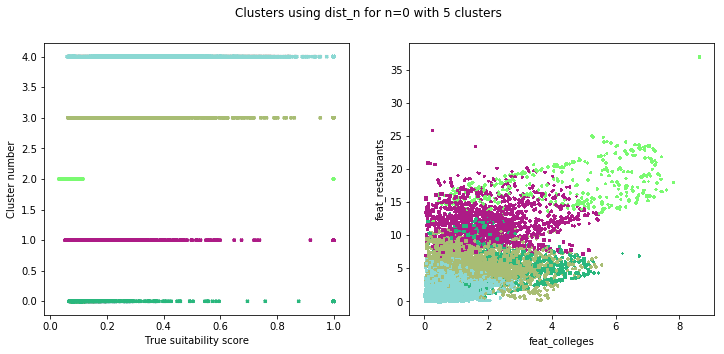


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2396  |         485 |         174 |         133
cluster1 :        1338  |        1179 |         956 |        1369


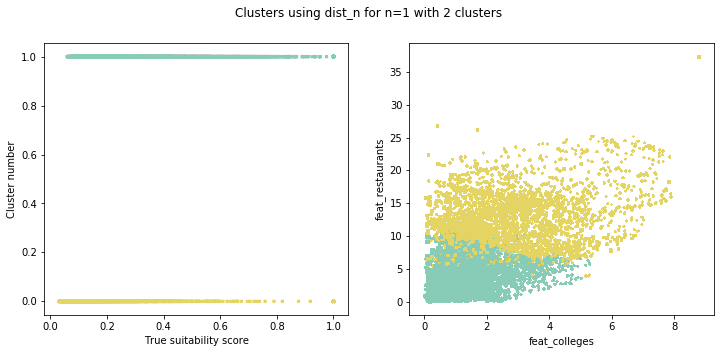


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1337  |         212 |          79 |          83
cluster1 :        1901  |         579 |         193 |         135
cluster2 :         496  |         873 |         858 |        1284


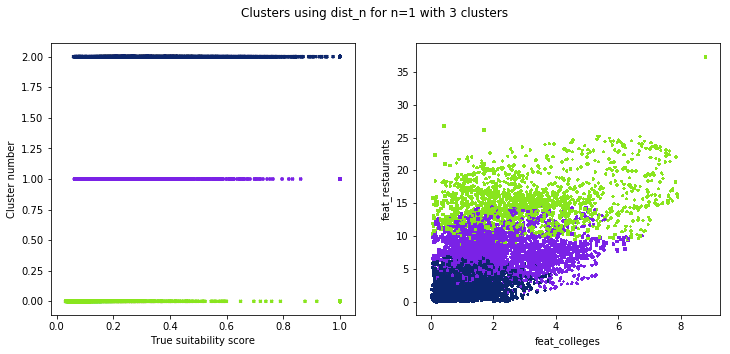


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         398  |         798 |         822 |        1260
cluster1 :        1109  |         327 |         129 |         103
cluster2 :        1653  |         527 |         179 |         135
cluster3 :         574  |          12 |           0 |           4


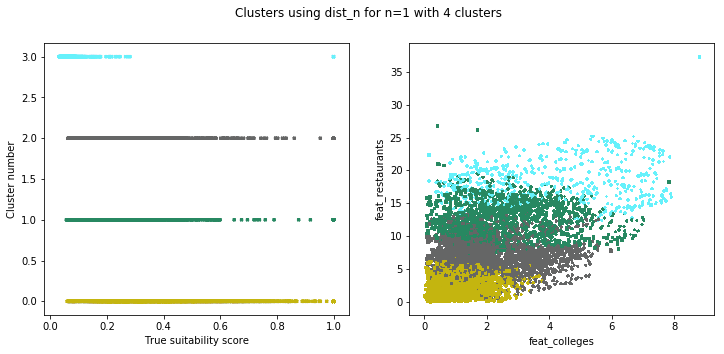


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1040  |         266 |         102 |          71
cluster1 :         180  |         632 |         772 |        1207
cluster2 :         498  |          12 |           0 |           7
cluster3 :        1104  |         536 |         175 |         154
cluster4 :         912  |         218 |          81 |          63


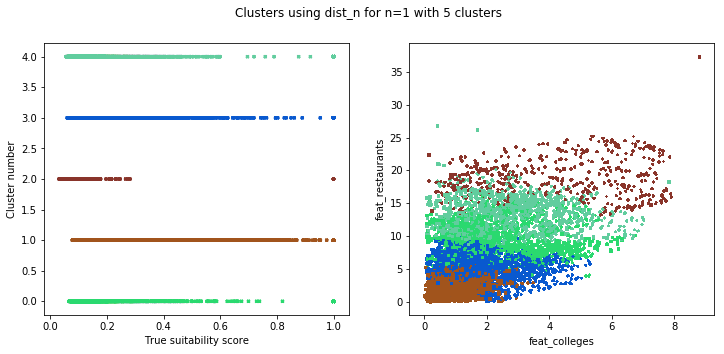


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2472  |         495 |         179 |         143
cluster1 :        1262  |        1169 |         951 |        1359


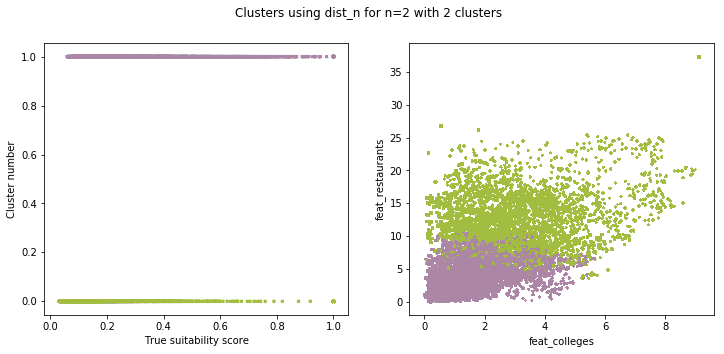


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         473  |         856 |         838 |        1259
cluster1 :        1377  |         206 |          76 |          75
cluster2 :        1884  |         602 |         216 |         168


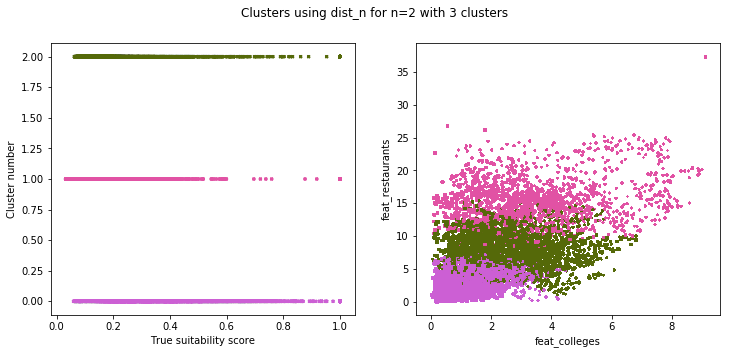


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         660  |          12 |           0 |           5
cluster1 :         245  |         693 |         797 |        1228
cluster2 :        1261  |         363 |         143 |         109
cluster3 :        1568  |         596 |         190 |         160


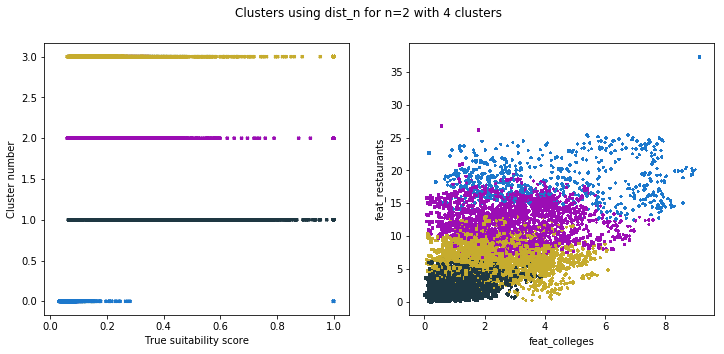


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1216  |         584 |         196 |         148
cluster1 :         159  |         600 |         768 |        1213
cluster2 :         529  |          12 |           0 |           4
cluster3 :         825  |         182 |          76 |          61
cluster4 :        1005  |         286 |          90 |          76


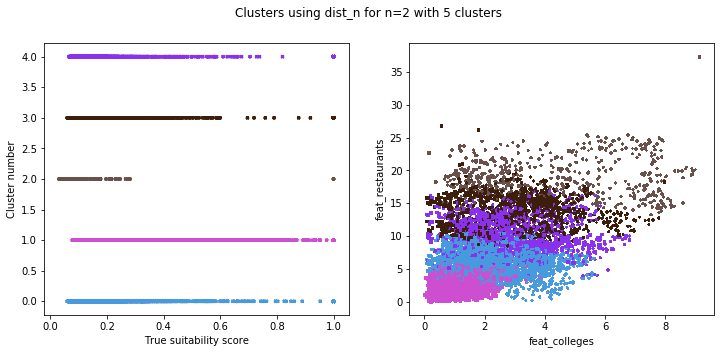

In [70]:
featFunList = [dist_n]
featFunStr = ['dist_n']
nClsList = [2,3,4,5]

for ind in range(len(featFunList)):
    featFun = featFunList[ind]
    featFunName = featFunStr[ind]
    if featFunName in set(('dist_n', 'prox_n')):
        nList = [0,1,2]
    else :
        nList = [5,7,9]
    
    for nInd in range(len(nList)):
        n = nList[nInd]
        for nCls in nClsList:
            X = featureVector(df, featureFun=featFun, n=n)
            kmeans = KMeans(n_clusters=nCls, random_state=0, init='k-means++').fit(X)
            pred_clusters = kmeans.labels_
            plotTitle = "Clusters using {} for n={} with {} clusters".format(featFunName, n, nCls)
            
            plot_clusters(y, pred_clusters,plotTitle, plot_vars=True, featFun=featFun, n=n)


### Features from dist_0_n : distances for $0^{th}$ to $n^{th}$ nearest venues of each category


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2488  |         488 |         183 |         149
cluster1 :        1246  |        1176 |         947 |        1353


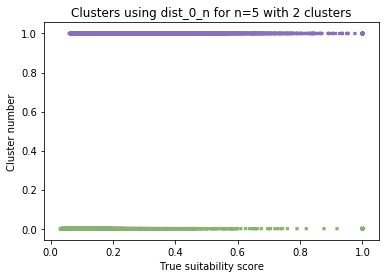


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1302  |         185 |          60 |          69
cluster1 :         464  |         866 |         836 |        1265
cluster2 :        1968  |         613 |         234 |         168


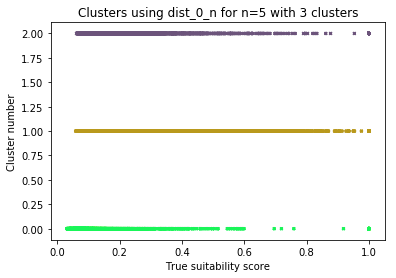


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1314  |         370 |         141 |         105
cluster1 :         238  |         707 |         799 |        1234
cluster2 :        1652  |         575 |         190 |         158
cluster3 :         530  |          12 |           0 |           5


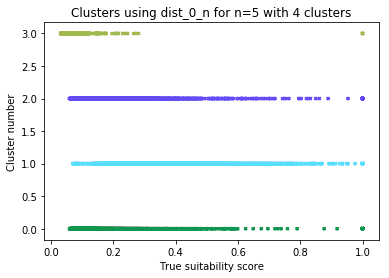


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1218  |         333 |         116 |          75
cluster1 :         113  |         572 |         753 |        1194
cluster2 :        1027  |         549 |         184 |         159
cluster3 :         968  |         198 |          77 |          70
cluster4 :         408  |          12 |           0 |           4


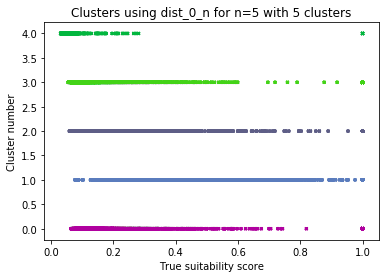


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2530  |         515 |         189 |         149
cluster1 :        1204  |        1149 |         941 |        1353


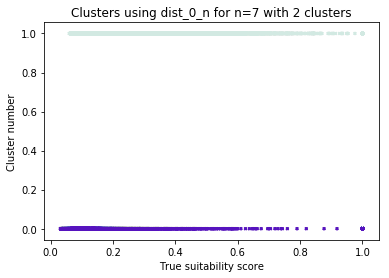


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2011  |         627 |         237 |         183
cluster1 :        1298  |         187 |          57 |          68
cluster2 :         425  |         850 |         836 |        1251


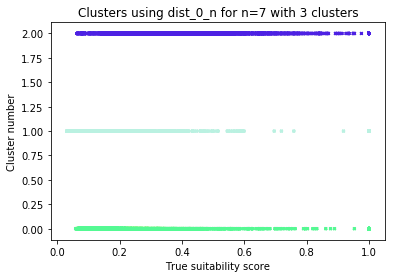


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1333  |         371 |         144 |         108
cluster1 :         199  |         686 |         792 |        1229
cluster2 :        1662  |         595 |         194 |         158
cluster3 :         540  |          12 |           0 |           7


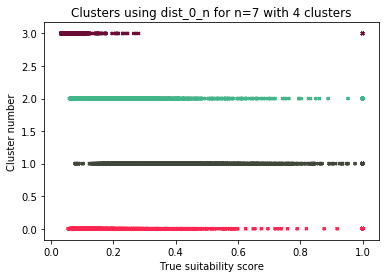


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1227  |         350 |         126 |          77
cluster1 :          97  |         564 |         744 |        1190
cluster2 :        1040  |         549 |         191 |         161
cluster3 :         389  |          12 |           0 |           5
cluster4 :         981  |         189 |          69 |          69


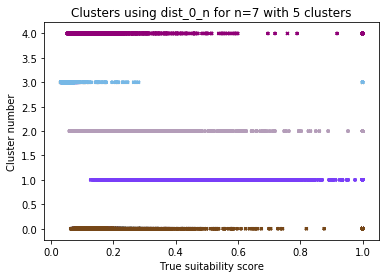


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2566  |         532 |         191 |         151
cluster1 :        1168  |        1132 |         939 |        1351


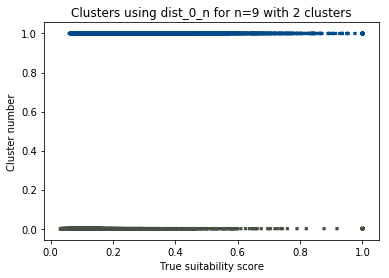


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1311  |         189 |          62 |          70
cluster1 :         370  |         832 |         827 |        1247
cluster2 :        2053  |         643 |         241 |         185


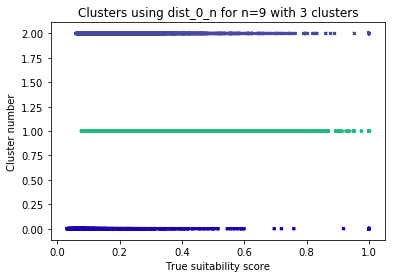


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        1327  |         365 |         143 |         107
cluster1 :         195  |         697 |         793 |        1230
cluster2 :        1669  |         590 |         194 |         158
cluster3 :         543  |          12 |           0 |           7


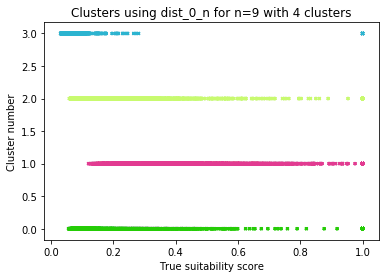


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         978  |         199 |          68 |          63
cluster1 :          99  |         560 |         744 |        1196
cluster2 :        1251  |         343 |         127 |          83
cluster3 :         398  |          12 |           0 |           7
cluster4 :        1008  |         550 |         191 |         153


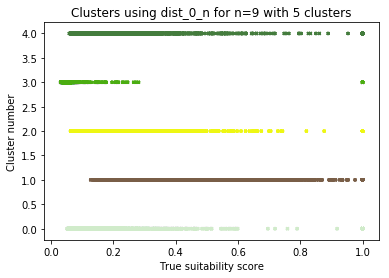

In [71]:
featFunList = [dist_0_n]
featFunStr = ['dist_0_n']
nClsList = [2,3,4,5]

for ind in range(len(featFunList)):
    featFun = featFunList[ind]
    featFunName = featFunStr[ind]
    if featFunName in set(('dist_n', 'prox_n')):
        nList = [0,1,2]
    else :
        nList = [5,7,9]
    
    for nInd in range(len(nList)):
        n = nList[nInd]
        for nCls in nClsList:
            X = featureVector(df, featureFun=featFun, n=n)
            kmeans = KMeans(n_clusters=nCls, random_state=0, init='k-means++').fit(X)
            pred_clusters = kmeans.labels_
            plotTitle = "Clusters using {} for n={} with {} clusters".format(featFunName, n, nCls)
            
            plot_clusters(y, pred_clusters,plotTitle)


### Features from prox_n : proximity for $n^{th}$ nearest venue of each category


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3572  |        1162 |         439 |         252
cluster1 :         162  |         502 |         691 |        1250


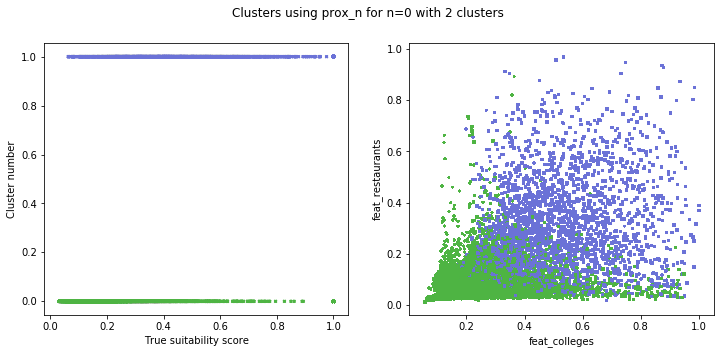


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         506  |         724 |         533 |         583
cluster1 :        3194  |         777 |         207 |          73
cluster2 :          34  |         163 |         390 |         846


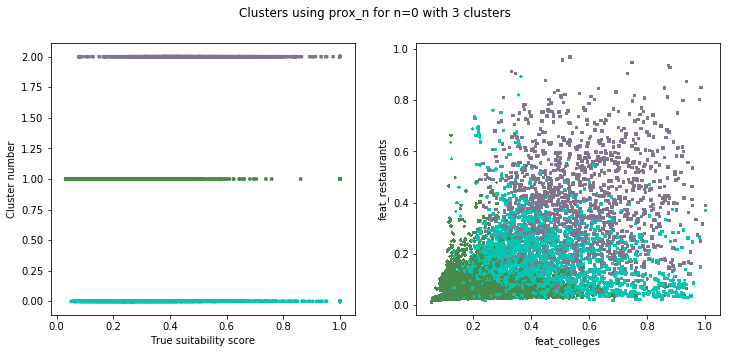


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         164  |         433 |         424 |         575
cluster1 :        2571  |         457 |          84 |          26
cluster2 :          16  |          95 |         296 |         693
cluster3 :         983  |         679 |         326 |         208


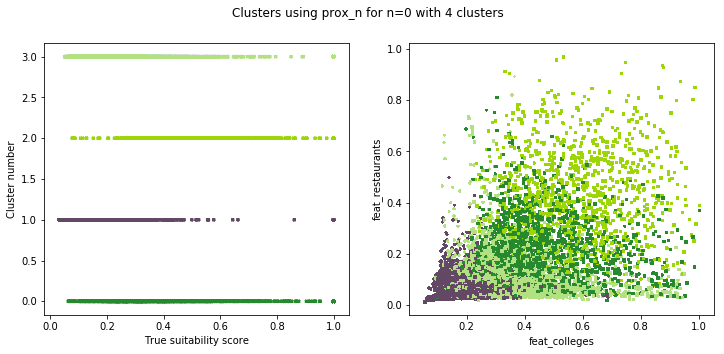


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2436  |         411 |          67 |          26
cluster1 :        1037  |         642 |         282 |         128
cluster2 :         127  |         362 |         394 |         518
cluster3 :         121  |         174 |         130 |         203
cluster4 :          13  |          75 |         257 |         627


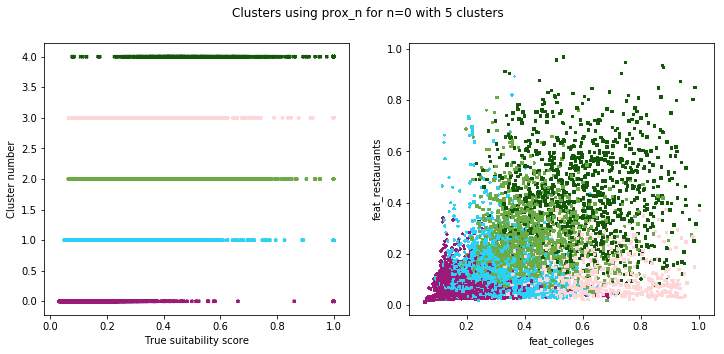


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3603  |        1174 |         416 |         286
cluster1 :         131  |         490 |         714 |        1216


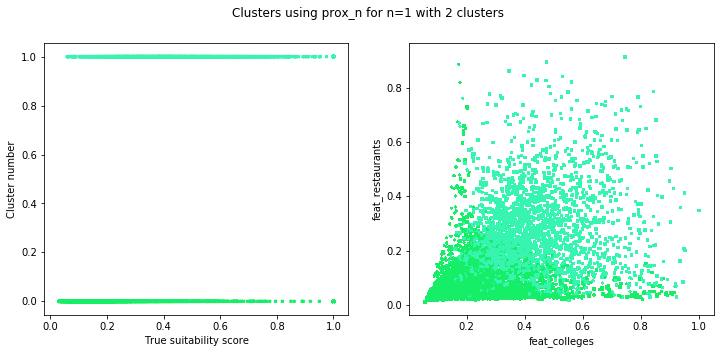


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         384  |         738 |         554 |         592
cluster1 :          22  |         130 |         355 |         803
cluster2 :        3328  |         796 |         221 |         107


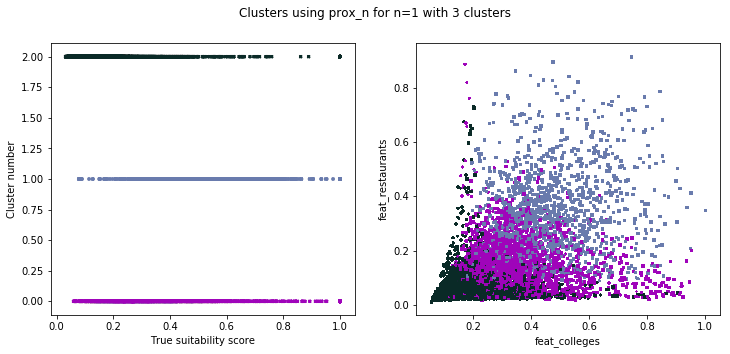


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         725  |         693 |         334 |         284
cluster1 :         101  |         388 |         450 |         631
cluster2 :        2901  |         533 |         114 |          54
cluster3 :           7  |          50 |         232 |         533


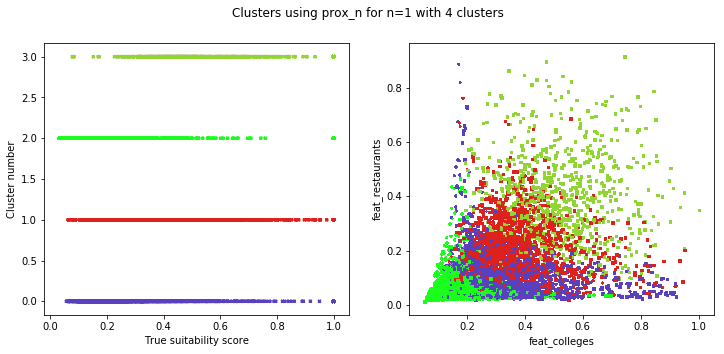


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2708  |         448 |          85 |          46
cluster1 :         109  |         262 |         171 |         237
cluster2 :         863  |         671 |         304 |         215
cluster3 :          47  |         239 |         343 |         489
cluster4 :           7  |          44 |         227 |         515


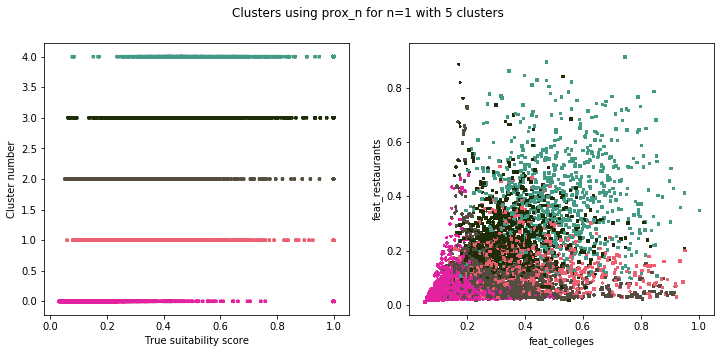


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3617  |        1171 |         418 |         295
cluster1 :         117  |         493 |         712 |        1207


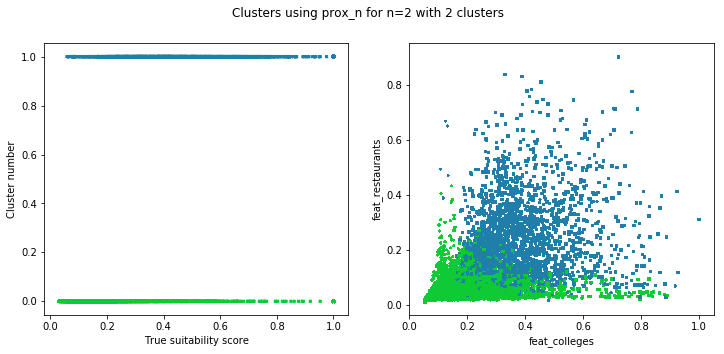


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3339  |         785 |         235 |         154
cluster1 :          34  |         146 |         383 |         826
cluster2 :         361  |         733 |         512 |         522


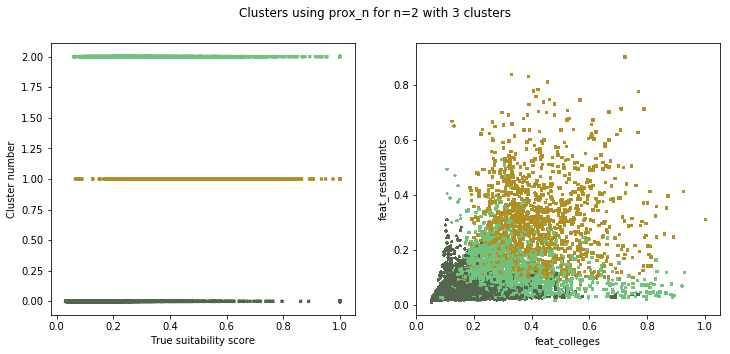


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2937  |         534 |         135 |          90
cluster1 :           7  |          52 |         237 |         556
cluster2 :         698  |         674 |         309 |         253
cluster3 :          92  |         404 |         449 |         603


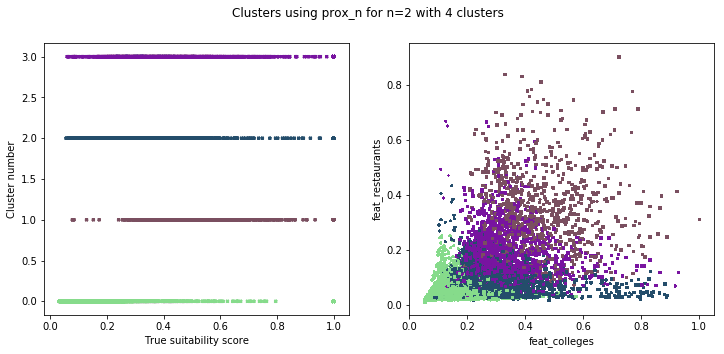


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :          19  |         174 |         297 |         505
cluster1 :        2827  |         460 |         121 |          71
cluster2 :         777  |         696 |         310 |         251
cluster3 :           5  |          20 |         172 |         400
cluster4 :         106  |         314 |         230 |         275


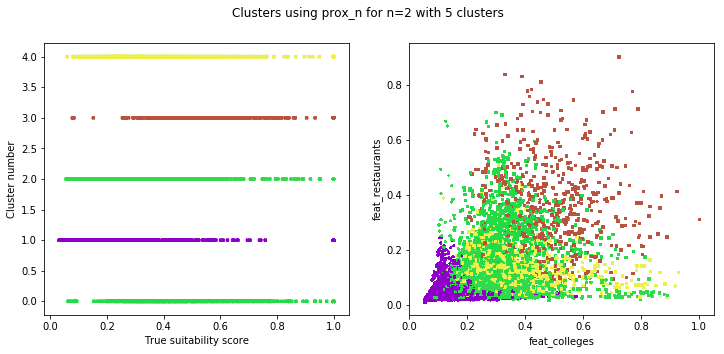

In [72]:
featFunList = [prox_n]
featFunStr = ['prox_n']
nClsList = [2,3,4,5]

for ind in range(len(featFunList)):
    featFun = featFunList[ind]
    featFunName = featFunStr[ind]
    if featFunName in set(('dist_n', 'prox_n')):
        nList = [0,1,2]
    else :
        nList = [5,7,9]
    
    for nInd in range(len(nList)):
        n = nList[nInd]
        for nCls in nClsList:
            X = featureVector(df, featureFun=featFun, n=n)
            kmeans = KMeans(n_clusters=nCls, random_state=0, init='k-means++').fit(X)
            pred_clusters = kmeans.labels_
            plotTitle = "Clusters using {} for n={} with {} clusters".format(featFunName, n, nCls)
            
            plot_clusters(y, pred_clusters,plotTitle, plot_vars=True, featFun=featFun, n=n)


### Features from prox_0_n : proximities for $0^{th}$ to $n^{th}$ nearest venues of each category


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3618  |        1186 |         434 |         305
cluster1 :         116  |         478 |         696 |        1197


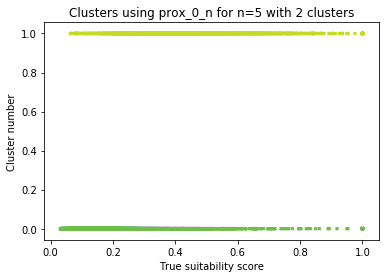


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         358  |         719 |         522 |         532
cluster1 :          26  |         138 |         382 |         840
cluster2 :        3350  |         807 |         226 |         130


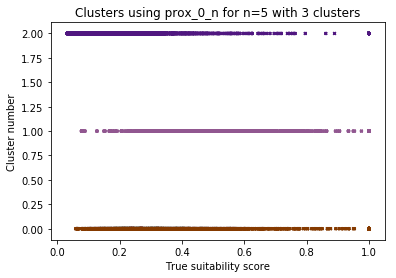


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2972  |         543 |         136 |          62
cluster1 :           6  |          56 |         242 |         562
cluster2 :          94  |         383 |         431 |         579
cluster3 :         662  |         682 |         321 |         299


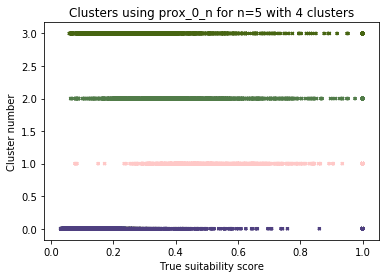


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :          13  |         139 |         235 |         470
cluster1 :         766  |         683 |         336 |         266
cluster2 :         101  |         324 |         279 |         338
cluster3 :        2850  |         496 |         113 |          52
cluster4 :           4  |          22 |         167 |         376


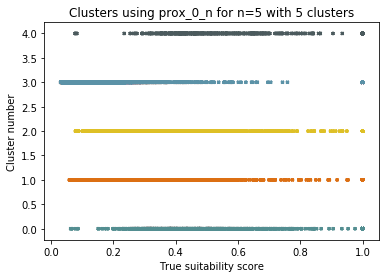


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3622  |        1172 |         426 |         297
cluster1 :         112  |         492 |         704 |        1205


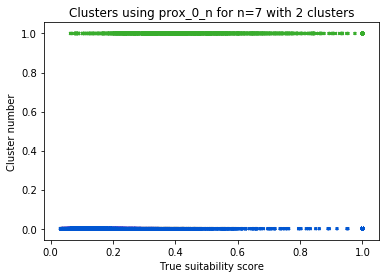


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3359  |         805 |         232 |         145
cluster1 :         348  |         715 |         496 |         501
cluster2 :          27  |         144 |         402 |         856


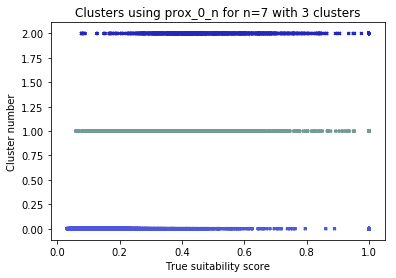


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2966  |         532 |         136 |          64
cluster1 :           5  |          56 |         245 |         564
cluster2 :         670  |         676 |         312 |         281
cluster3 :          93  |         400 |         437 |         593


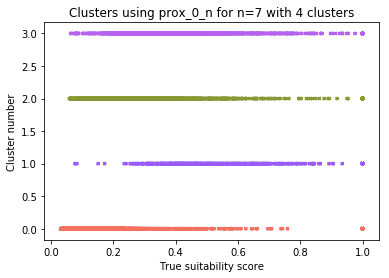


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2891  |         496 |         122 |          63
cluster1 :         104  |         324 |         285 |         350
cluster2 :           2  |          20 |         164 |         374
cluster3 :          10  |         139 |         238 |         458
cluster4 :         727  |         685 |         321 |         257


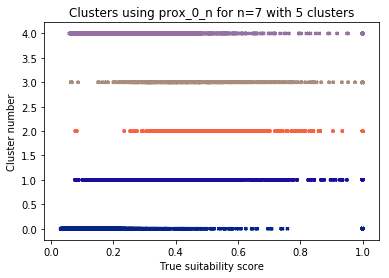


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3620  |        1159 |         412 |         293
cluster1 :         114  |         505 |         718 |        1209


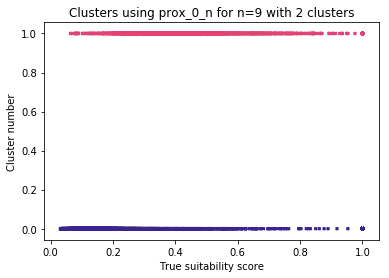


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        3357  |         800 |         229 |         150
cluster1 :         350  |         718 |         491 |         495
cluster2 :          27  |         146 |         410 |         857


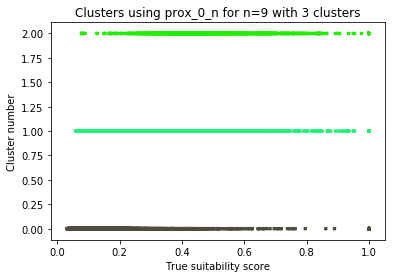


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :         671  |         668 |         308 |         270
cluster1 :           3  |          56 |         246 |         562
cluster2 :        2967  |         531 |         138 |          66
cluster3 :          93  |         409 |         438 |         604


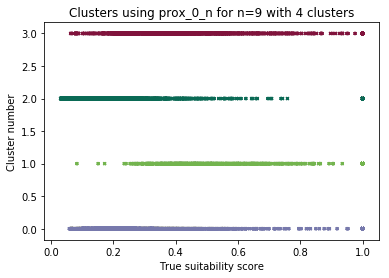


             [0.00,0.20) | [0.20,0.33) | [0.33,0.5) | [0.50,1.0]
cluster0 :        2877  |         477 |         122 |          63
cluster1 :           1  |          23 |         165 |         373
cluster2 :         109  |         346 |         287 |         351
cluster3 :           8  |         134 |         245 |         470
cluster4 :         739  |         684 |         311 |         245


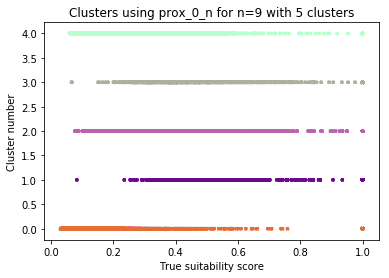

In [73]:
featFunList = [prox_0_n]
featFunStr = ['prox_0_n']
nClsList = [2,3,4,5]

for ind in range(len(featFunList)):
    featFun = featFunList[ind]
    featFunName = featFunStr[ind]
    if featFunName in set(('dist_n', 'prox_n')):
        nList = [0,1,2]
    else :
        nList = [5,7,9]
    
    for nInd in range(len(nList)):
        n = nList[nInd]
        for nCls in nClsList:
            X = featureVector(df, featureFun=featFun, n=n)
            kmeans = KMeans(n_clusters=nCls, random_state=0, init='k-means++').fit(X)
            pred_clusters = kmeans.labels_
            plotTitle = "Clusters using {} for n={} with {} clusters".format(featFunName, n, nCls)
            
            plot_clusters(y, pred_clusters,plotTitle, plot_vars=False)


# Summary

We did simple K-Means clustering for all of the datapoints using both distances and proximities (for just one venue for each category and for multiple venues for each category). The locations explored here do not fall into nicely separated clusters for different ranges of suitability scores (using proximity to nearest existing sports facility as suitability score). This is not surprising at all. After all, the city does have a lot of densely populated neighborhoods with schools and gyms and restaurants that don't have sports facilities. A simple K-Means clustering is clearly not good enough to pick out patterns in this scenario. 

Can a more sophisticated clustering algorithm do the job? I don't know. I will not try though. Even if we did manage to get a good clustering using another algorithm, it would still not rank potential locations by suitability. In that case, why bother at all? We will leave clustering here. In the next notebook, we will use the Multi-layer perceptron model to identify a bunch of locations where a sports facility could be built. 